In [2]:
!pip install torchsummary

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!conda install -c anaconda diffusers-torch

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::aiohttp==3.8.3=py311h5eee18b_0
  - conda-forge/linux-64::deepspeed==0.9.5=cpu_py311h057d117_0
  - pytorch/noarch::ignite==0.4.12=py_0
  - pytorch/linux-64::torchvision==0.15.2=py311_cu118
  - conda-forge/noarch::accelerate==0.21.0=pyhd8ed1ab_0
  - defaults/linux-64::huggingface_hub==0.15.1=py311h06a4308_0
  - pytorch/linux-64::torchaudio==2.0.2=py311_cu118
  - defaults/linux-64::mkl_fft==1.3.6=py311ha02d727_1
  - defaults/linux-64::datasets==2.12.0=py311h06a4308_0
  - conda-forge/noarch::transformers==4.28.1=pyhd8ed1ab_0
  - defaults/linux-64::bottleneck==1.3.5=py311hbed6279_0
  - defaults/linux-64::numexpr==2.8.4=py311h65dcdc2_1
  - defaults/linux-64::scipy==1.11.1=py311h08b1b3b_0
  - defaults/linux-64::pandas==2.0.3=py311ha02d727_0
  - defaults/linux-64::nltk==3.8.1=py311h06a4308_0
  - defaults/linux-64::pyarrow

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*(x-0.5))
    #transforms.Lambda(lambda x: x*2 - 1)
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 1024
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 10557178.74it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112579641.10it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3145804.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20137979.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



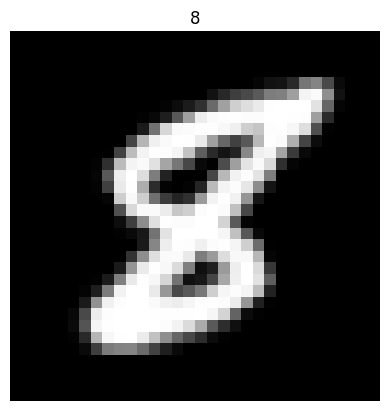

In [3]:
# Show example
for i in train_loader:
  x, y = i
  plt.imshow(x[1][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[1].numpy())
  break

In [9]:
import diffusers
from tqdm.auto import tqdm

model = diffusers.UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=(128,128,256),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)

In [10]:
print('Output shape:', model(x, timestep=0)["sample"].shape)

Output shape: torch.Size([1024, 1, 32, 32])


In [8]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [20]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, net, D, sigma=0.001, tmin=1e-10, xmin=-1, xmax=1):
        super(BayesianFlowNetwork2D, self).__init__()
        self.sigma = torch.tensor(sigma)
        self.D = D
        self.t_min = tmin
        self.xmin = xmin
        self.xmax = xmax
        self.net = net

    def forward(self, mu, t, ema):
        if ema is not None:
          with ema.average_parameters():
            output = self.net(mu,t)['sample']  # (B, D, D, K)
        else:
          output = self.net(mu,t)['sample']  # (B, D, D, K)

        return output

    def CTS_OUTPUT_PREDICTION(self, mu, t, gamma,ema=None):
        eps_hat = self.forward(mu, t, ema=ema)
        mask = t>=self.t_min
        eps_hat = eps_hat*mask[:,None,None,None]
        x_hat = (mu/gamma[:, None, None, None]) - ((1-gamma[:, None, None, None])/gamma[:, None, None, None]).sqrt()*eps_hat
        x_hat = torch.clip(x_hat,self.xmin,self.xmax)
        return x_hat

    def process(self, x, t=None, training=True):

        # Step 1: Sample t from U(0, 1)
        if t is None:
          t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        else:
          t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

        # Step 2: Calculate gamma
        gamma = 1- self.sigma**(2*t)  # (B,


        # Step 3: Sample mu from N(gamma*X, gamma*(1-gamma)*I)
        mean = gamma[:, None, None, None] * (x)
        std = torch.sqrt(gamma*(1-gamma))
        eps = torch.randn_like(mean)
        mu = mean + std[:, None, None, None] * eps

        # Step 5: CTS_OUTPUT_PREDICTION
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, gamma)  # (B, K, D, D)
       

        L_infinity = -torch.log(self.sigma)*(self.sigma**(-2*t[:, None, None, None]))*((x - x_hat) ** 2)

        if training:
          return L_infinity.mean()
        else:
          return L_infinity.mean(), mu, t

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=100, ema=None, device='cpu'):
        self.eval()
        mu = torch.zeros((batch_size, 1, self.D, self.D), device=device)
        rho = 1

        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            if t<1e-7:
              t+=1e-7
            t = t * torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)

            x_hat = self.CTS_OUTPUT_PREDICTION(mu, t, 1- self.sigma**(2*t))  # (B, D, D, K)
            alpha = (self.sigma**((-2 * i)/nb_steps))*(1-self.sigma**(2/nb_steps))
            std = torch.sqrt(1/alpha)
            eps = torch.randn_like(x_hat)
            y = x_hat + std * eps  # (B, D, D, K)

            mu = (rho*mu + alpha*y)/(rho+alpha)
            rho = rho+alpha
        t_final = torch.ones((mu.shape[0]), device=mu.device, dtype=mu.dtype)
        x_hat = self.CTS_OUTPUT_PREDICTION(mu, t_final, 1- self.sigma**(2*t_final))
        return x_hat

In [21]:
from torch.optim import AdamW

bfn = BayesianFlowNetwork2D(model, 32).to(device)
#bfn = MyUNet()
#ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)

# bfn.cuda()
#ema.to(device)

optim = AdamW(bfn.parameters(), lr=0.0002, betas=(0.9, 0.98), weight_decay=0.01)


In [22]:
losses = []

epochs = 1000
best_loss = 10000
k = 0
early_stopping = False
patience = 1e6
J = 0
for i in range(epochs):
  for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}"):
      optim.zero_grad()

      loss = bfn.process(X.to(device))
      loss.backward()

      optim.step()

      losses.append(loss.item())

      # if (J+1)%100 == 0:
        # print(loss)
      J+=1

      if loss.item() < best_loss:
        best_loss = loss.item()
        k = 0
      else:
        k += 1
        if k == patience:
          k = 0
          early_stopping = True
          break
  print(sum(losses)/len(losses))
  if early_stopping:
    break


plt.plot(losses)

Epoch 1/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.02008516069943622


Epoch 2/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019908356417159913


Epoch 3/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01986763405345254


Epoch 4/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.0198659662757132


Epoch 5/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01982037482499066


Epoch 6/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01978109311838608


Epoch 7/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019730650447760022


Epoch 8/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019753939211684262


Epoch 9/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01971046977699252


Epoch 10/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019705060392744462


Epoch 11/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019671708049800805


Epoch 12/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019625555313492225


Epoch 13/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019608350244813357


Epoch 14/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019592597460505026


Epoch 15/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019566279506615998


Epoch 16/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01956012143587725


Epoch 17/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01953925229497588


Epoch 18/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01950721651589298


Epoch 19/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01948405238970064


Epoch 20/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019469899954116444


Epoch 21/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019457681254875382


Epoch 22/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019438510403347035


Epoch 23/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019411982836678086


Epoch 24/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01940036081251199


Epoch 25/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019392293894947586


Epoch 26/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019388137075617772


Epoch 27/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01936477095202051


Epoch 28/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019366645002760193


Epoch 29/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01935237009254622


Epoch 30/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01934264906087501


Epoch 31/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019326668535142796


Epoch 32/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01931007690352814


Epoch 33/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019307546455338484


Epoch 34/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01929781566989624


Epoch 35/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019283901682669257


Epoch 36/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01926761325676759


Epoch 37/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019257391734279955


Epoch 38/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019239094396629415


Epoch 39/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019229371468983802


Epoch 40/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019218611175004962


Epoch 41/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01921450534358824


Epoch 42/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01920782878417657


Epoch 43/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019197219016546568


Epoch 44/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01918672180256716


Epoch 45/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01917467545332096


Epoch 46/1000: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.019167359133217383


Epoch 47/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019157083958301395


Epoch 48/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019154992587943325


Epoch 49/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019143561592608414


Epoch 50/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01914139973283824


Epoch 51/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019131721335071072


Epoch 52/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01912172522148144


Epoch 53/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019117437429942947


Epoch 54/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019107263323038873


Epoch 55/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019104747216465476


Epoch 56/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019099828655229426


Epoch 57/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019090243037806674


Epoch 58/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01908193384789797


Epoch 59/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019077082792512648


Epoch 60/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019067847391979843


Epoch 61/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.019058509231147814


Epoch 62/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01904931539509745


Epoch 63/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019041687917121644


Epoch 64/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01903940700596372


Epoch 65/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.019031757050991603


Epoch 66/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01902663776541964


Epoch 67/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.0190175582779406


Epoch 68/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019009467339930558


Epoch 69/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.019007776391234233


Epoch 70/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018999897447791285


Epoch 71/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.0189944013413402


Epoch 72/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018988140006312878


Epoch 73/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01898122392248839


Epoch 74/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018974064406906854


Epoch 75/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018966135567864455


Epoch 76/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018960454599868694


Epoch 77/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018954482373369243


Epoch 78/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018945350906067325


Epoch 79/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018940172075459602


Epoch 80/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018931925748040805


Epoch 81/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01892504677605987


Epoch 82/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018918550882254408


Epoch 83/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018912546811916342


Epoch 84/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018905978298635554


Epoch 85/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01890192862770939


Epoch 86/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018894334667122557


Epoch 87/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018889068365684904


Epoch 88/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018881212623261822


Epoch 89/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018879573331790023


Epoch 90/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01887062564667616


Epoch 91/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01886391136319994


Epoch 92/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018862375153287664


Epoch 93/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018857659931247606


Epoch 94/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01885575220879507


Epoch 95/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01885194284450944


Epoch 96/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018846870903162508


Epoch 97/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018841484484426962


Epoch 98/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018836553498783024


Epoch 99/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01883272144945389


Epoch 100/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018832899193137378


Epoch 101/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01883023584558172


Epoch 102/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01882645058677457


Epoch 103/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018822030212116543


Epoch 104/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018813662888631566


Epoch 105/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018810437160414056


Epoch 106/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018806219744717335


Epoch 107/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018799119771769634


Epoch 108/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01879591400073274


Epoch 109/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018792665880095243


Epoch 110/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018788851980257704


Epoch 111/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.0187844157087817


Epoch 112/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018779122722633948


Epoch 113/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01877484681693527


Epoch 114/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01876974368601962


Epoch 115/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018762981525554362


Epoch 116/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018759457131848827


Epoch 117/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018755059162302933


Epoch 118/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018750290974441683


Epoch 119/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01874845908372945


Epoch 120/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018745121500312777


Epoch 121/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018737537437134896


Epoch 122/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018732617741306273


Epoch 123/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018729171789340717


Epoch 124/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018725330689453513


Epoch 125/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018723631944065375


Epoch 126/1000: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.018719556914927587


Epoch 127/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018715529052803413


Epoch 128/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018709681827650933


Epoch 129/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018706044788256868


Epoch 130/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018701546766820717


Epoch 131/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018697498277430277


Epoch 132/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018695409426682796


Epoch 133/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018691619703380246


Epoch 134/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018688192885687592


Epoch 135/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018685656789355846


Epoch 136/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01868140597557064


Epoch 137/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018678675448082063


Epoch 138/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018675391689364763


Epoch 139/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01867300281515773


Epoch 140/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018669912462476776


Epoch 141/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018665597027149542


Epoch 142/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01866226547223592


Epoch 143/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018658920686417804


Epoch 144/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018656453643570322


Epoch 145/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01865268666797967


Epoch 146/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018647586832863945


Epoch 147/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018642081816797884


Epoch 148/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018637108964976938


Epoch 149/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018633435360583893


Epoch 150/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018628098475878353


Epoch 151/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01862427699564131


Epoch 152/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018622347619072978


Epoch 153/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018619101859672072


Epoch 154/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018615488361381938


Epoch 155/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018612075958578167


Epoch 156/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018607927651437196


Epoch 157/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018605175799797063


Epoch 158/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018602500683645006


Epoch 159/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018598090539082873


Epoch 160/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018594932197731274


Epoch 161/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018590973090219245


Epoch 162/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018588418016772617


Epoch 163/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01858641505595833


Epoch 164/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01858355777571844


Epoch 165/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018579285013531042


Epoch 166/1000: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.018575231648798235


Epoch 167/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018571475512884714


Epoch 168/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01856780935767016


Epoch 169/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018564578828986288


Epoch 170/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018562261310544382


Epoch 171/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018557803576007382


Epoch 172/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018556064553210086


Epoch 173/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018553540455762296


Epoch 174/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018549738982273238


Epoch 175/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018546314768709656


Epoch 176/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018544356677432233


Epoch 177/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018540373290433693


Epoch 178/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01853776280072074


Epoch 179/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018535895089311714


Epoch 180/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01853299028610218


Epoch 181/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018530147848716223


Epoch 182/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018527412206152394


Epoch 183/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018525273229547636


Epoch 184/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018521857337254755


Epoch 185/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018519008830121444


Epoch 186/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018516867237237878


Epoch 187/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018514391363205974


Epoch 188/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01851110223071496


Epoch 189/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018508947052749088


Epoch 190/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01850889287407142


Epoch 191/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018505616532056023


Epoch 192/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.01850176169694859


Epoch 193/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018497728529927905


Epoch 194/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018495530058814838


Epoch 195/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018493958654894824


Epoch 196/1000: 100%|██████████| 59/59 [00:33<00:00,  1.75it/s]


0.018491277807746218


Epoch 197/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018490790249896007


Epoch 198/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018487808368098775


Epoch 199/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018484607466455517


Epoch 200/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018482278137452016


Epoch 201/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.01847922482232273


Epoch 202/1000: 100%|██████████| 59/59 [00:33<00:00,  1.78it/s]


0.018477193103019506


Epoch 203/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018474481893966013


Epoch 204/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.01847250030669125


Epoch 205/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.0184702134718514


Epoch 206/1000: 100%|██████████| 59/59 [00:33<00:00,  1.76it/s]


0.018467498191347125


Epoch 207/1000: 100%|██████████| 59/59 [00:33<00:00,  1.77it/s]


0.018464551777383292


Epoch 208/1000:  66%|██████▌   | 39/59 [00:22<00:11,  1.72it/s]


KeyboardInterrupt: 

(0.0, 0.1)

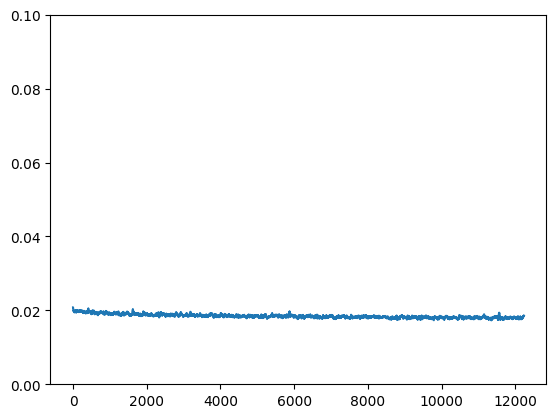

In [23]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

plt.plot(moving_average(losses, 20))
plt.ylim(0, 0.1)

In [25]:
x_hat = bfn.sample(device='cuda:2', nb_steps=1000, batch_size=16)

100%|██████████| 1000/1000 [00:07<00:00, 140.85it/s]


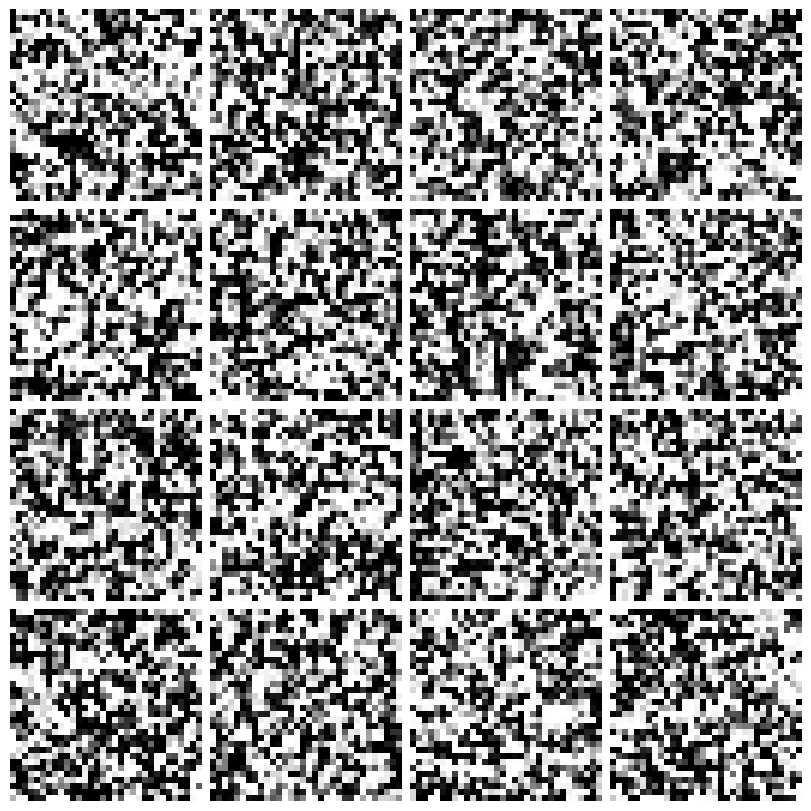

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i][0], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

tensor([218, 782, 803])